In [2]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import os

In [3]:
import nltk
#nltk.download('all')

In [4]:

# Step 2: Read and preprocess the data
def read_semeval_data(file_path):
    """
    Read SemEval Twitter data with custom parsing for the mixed format
    Returns DataFrame with columns: tweet_id, user_id, label, text
    """
    # Read all lines from the file
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    # Process lines in pairs (metadata and text alternating)
    data = []
    for i in range(0, len(lines), 2):
        if i + 1 < len(lines):  # ensure we have both metadata and text
            # Parse metadata line
            meta = lines[i].strip().split()
            if len(meta) >= 3:  # ensure we have all metadata parts
                tweet_id = meta[0]
                user_id = meta[1]
                label = meta[2]
                
                # Get corresponding text line
                text = lines[i + 1].strip()
                
                data.append({
                    'tweet_id': tweet_id,
                    'user_id': user_id,
                    'label': label,
                    'text': text
                })
    
    return pd.DataFrame(data)

In [5]:

# Read the training data
data_path = '/Users/Apexr/Downloads/FinalProjectData/SemEval2014TweetData'
train_file = os.path.join(data_path, 'corpus', 'downloaded-tweeti-b-dist.tsv')
train_df = read_semeval_data(train_file)

print("\nTraining data shape:", train_df.shape)
print("\nSample of processed data:")
print(train_df.head())
print("\nLabel distribution:")
print(train_df['label'].value_counts())


Training data shape: (4842, 4)

Sample of processed data:
             tweet_id    user_id                   label  \
0  264183816548130816   15140428              "positive"   
1  262163168678248449   35266263              "negative"   
2  262682041215234048  254373818  "objective-OR-neutral"   
3  264105751826538497  147088367              "positive"   
4  212392538055778304  274996324             "objective"   

                                                text  
0  263405084770172928\t591166521\t"negative"\tThe...  
1  264249301910310912\t18516728\t"negative"\tIran...  
2  264229576773861376\t518129399\t"neutral"\tNot ...  
3  264094586689953794\t332474633\t"negative"\tTal...  
4  254941790757601280\t557103111\t"negative"\tThe...  

Label distribution:
"positive"                1770
"neutral"                  862
"objective-OR-neutral"     848
"negative"                 749
"objective"                613
Name: label, dtype: int64


In [6]:
# Step 3: Define a simpler preprocessing function first
def basic_preprocess(tweet):
    """Basic preprocessing without tokenization"""
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    
    # Handle elongated words
    tweet = re.sub(r'(.)\1{2,}', r'\1\1', tweet)
    
    return tweet

In [7]:
# Test basic preprocessing #
sample_tweet = "@user I loooove this movie!!! #awesome http://movie.com"
processed_text = basic_preprocess(sample_tweet)
print("\nOriginal tweet:", sample_tweet)
print("Processed text:", processed_text)


Original tweet: @user I loooove this movie!!! #awesome http://movie.com
Processed text:  i loove this movie!! awesome 


In [8]:
def tokenize_tweet(processed_text):
    """Tokenize preprocessed text"""
    tokens = processed_text.split()
    try:
        # Try NLTK tokenization
        tokens = word_tokenize(processed_text)
    except:
        print("Warning: Using basic tokenization instead of NLTK")
    return tokens

In [9]:
# Test tokenization
tokens = tokenize_tweet(processed_text)
print("\nTokenized result:", tokens)


Tokenized result: ['i', 'loove', 'this', 'movie', '!', '!', 'awesome']


In [10]:
stop_words = set(stopwords.words('english'))


In [11]:
witter_stopwords = set()
try:
    with open(os.path.join(data_path, 'stopwords_twitter.txt'), 'r') as f:
        twitter_stopwords = set(f.read().splitlines())
    print("\nLoaded", len(twitter_stopwords), "Twitter stopwords")
except:
    print("\nNo custom Twitter stopwords file found")

def remove_stopwords(tokens):
    """Remove stopwords from tokens"""
    return [t for t in tokens if t not in stop_words and t not in twitter_stopwords]



Loaded 156 Twitter stopwords


In [12]:
cleaned_tokens = remove_stopwords(tokens)
print("\nTokens after stopword removal:", cleaned_tokens)



Tokens after stopword removal: ['loove', 'movie', '!', '!', 'awesome']


In [13]:
def extract_features(tokens):
    """Extract basic features from tokens"""
    features = {}
    
    # Bag of words features
    for token in tokens:
        features[f'contains({token})'] = True
    
    # Count features
    features['tweet_length'] = len(tokens)
    features['has_exclamation'] = '!' in tokens
    features['has_question'] = '?' in tokens
    features['uppercase_count'] = len([t for t in tokens if t.isupper()])
    
    return features

In [14]:
test_features = extract_features(cleaned_tokens)
print("\nExtracted features:", test_features)


Extracted features: {'contains(loove)': True, 'contains(movie)': True, 'contains(!)': True, 'contains(awesome)': True, 'tweet_length': 5, 'has_exclamation': True, 'has_question': False, 'uppercase_count': 0}


In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [16]:
# Function to preprocess tweets for vectorizer #
def preprocess_for_vectorizer(tweet):
    processed = basic_preprocess(tweet)
    tokens = tokenize_tweet(processed)
    clean_tokens = remove_stopwords(tokens)
    return ' '.join(clean_tokens)

In [17]:
vectorizer = CountVectorizer(
    max_features=5000,
    preprocessor=preprocess_for_vectorizer
)

In [18]:
if 'text' in train_df.columns:
    X = vectorizer.fit_transform(train_df['text'])
    y = train_df['label']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train classifier
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # Print results
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
else:
    print("\nNote: 'text' column not found in data. Skipping classification step.")


Classification Report:
                        precision    recall  f1-score   support

            "negative"       0.11      0.06      0.08       144
             "neutral"       0.18      0.10      0.13       176
           "objective"       0.13      0.05      0.07       132
"objective-OR-neutral"       0.09      0.07      0.08       168
            "positive"       0.36      0.66      0.47       349

              accuracy                           0.28       969
             macro avg       0.18      0.19      0.16       969
          weighted avg       0.21      0.28      0.23       969



In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


=== FINAL ANALYSIS RESULTS ===


Dataset Statistics:
--------------------------------------------------
Total number of tweets: 4842

Label distribution:
"positive"                1770
"neutral"                  862
"objective-OR-neutral"     848
"negative"                 749
"objective"                613
Name: label, dtype: int64

Feature Set Performance Comparison:
--------------------------------------------------


/Users/Apexr/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Apexr/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Apexr/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)


baseline results:
accuracy: 0.289 (±0.007)
precision_macro: 0.180 (±0.016)
recall_macro: 0.189 (±0.009)
f1_macro: 0.166 (±0.013)

tfidf results:
accuracy: 0.364 (±0.002)
precision_macro: 0.107 (±0.042)
recall_macro: 0.199 (±0.001)
f1_macro: 0.108 (±0.001)

tfidf_bigrams results:
accuracy: 0.360 (±0.003)
precision_macro: 0.114 (±0.032)
recall_macro: 0.198 (±0.001)
f1_macro: 0.109 (±0.001)

Sample Predictions:
--------------------------------------------------

True Label: "objective-OR-neutral"
Predicted: "positive"

True Label: "objective-OR-neutral"
Predicted: "positive"

True Label: "objective-OR-neutral"
Predicted: "positive"

True Label: "positive"
Predicted: "neutral"

True Label: "neutral"
Predicted: "positive"

Final Model Performance:
--------------------------------------------------

Classification Report:
                        precision    recall  f1-score   support

            "negative"       0.11      0.06      0.08       144
             "neutral"       0.18      0.1

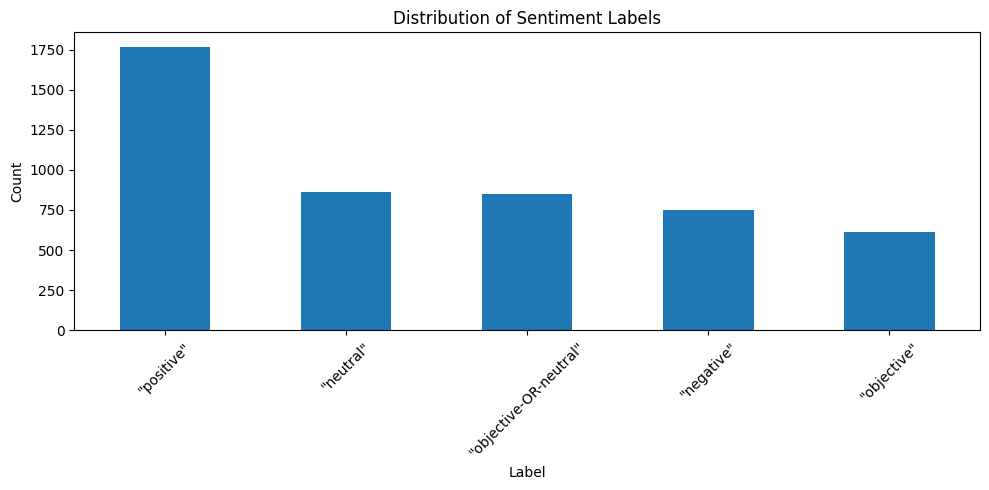

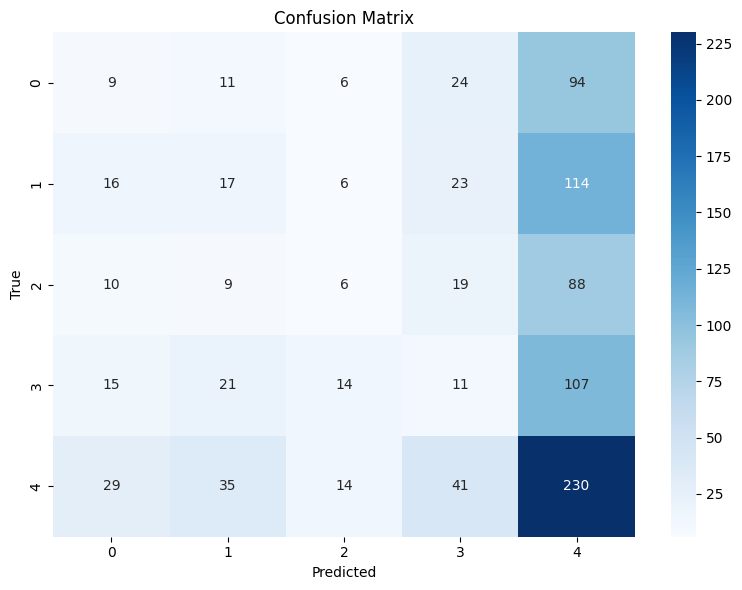


Summary of Model Performance Across Feature Sets:
--------------------------------------------------

baseline:
  accuracy: 0.289 ± 0.007
  precision_macro: 0.180 ± 0.016
  recall_macro: 0.189 ± 0.009
  f1_macro: 0.166 ± 0.013

tfidf:
  accuracy: 0.364 ± 0.002
  precision_macro: 0.107 ± 0.042
  recall_macro: 0.199 ± 0.001
  f1_macro: 0.108 ± 0.001

tfidf_bigrams:
  accuracy: 0.360 ± 0.003
  precision_macro: 0.114 ± 0.032
  recall_macro: 0.198 ± 0.001
  f1_macro: 0.109 ± 0.001


In [28]:
# Final Results Section
print("\n=== FINAL ANALYSIS RESULTS ===\n")

# 1. Dataset Statistics
print("\nDataset Statistics:")
print("-" * 50)
print(f"Total number of tweets: {len(train_df)}")
print("\nLabel distribution:")
print(train_df['label'].value_counts())

# 2. Feature Set Performance
print("\nFeature Set Performance Comparison:")
print("-" * 50)
feature_comparison = compare_feature_sets(train_df)
for feature_set, results in feature_comparison.items():
    print(f"\n{feature_set} results:")
    for metric, values in results.items():
        print(f"{metric}: {values['mean']:.3f} (±{values['std']:.3f})")

# 3. Sample Predictions
print("\nSample Predictions:")
print("-" * 50)
n_samples = min(5, len(y_pred))
sample_indices = np.random.choice(len(y_pred), n_samples, replace=False)

for idx in sample_indices:
    print(f"\nTrue Label: {y_test.iloc[idx]}")
    print(f"Predicted: {y_pred[idx]}")

# 4. Final Performance Metrics
print("\nFinal Model Performance:")
print("-" * 50)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 5. Analysis of Misclassifications
print("\nMisclassification Analysis:")
print("-" * 50)
true_labels = list(y_test)
pred_labels = list(y_pred)
mismatches = [(true, pred) for true, pred in zip(true_labels, pred_labels) if true != pred]
if mismatches:
    mismatch_counts = {}
    for true, pred in mismatches:
        pair = f"{true} → {pred}"
        mismatch_counts[pair] = mismatch_counts.get(pair, 0) + 1
    
    print("\nMost common misclassifications (True → Predicted):")
    for pair, count in sorted(mismatch_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"{pair}: {count} times")

# 6. Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Label Distribution
plt.figure(figsize=(10, 5))
train_df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# 7. Print Feature Set Performance Summary
print("\nSummary of Model Performance Across Feature Sets:")
print("-" * 50)
for feature_set, results in feature_comparison.items():
    print(f"\n{feature_set}:")
    for metric, values in results.items():
        print(f"  {metric}: {values['mean']:.3f} ± {values['std']:.3f}")